# Series Temporales - Defunciones

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#leo archivo de defunciones

defunciones = pd.read_excel('/Users/andreac.henechesierra/Desktop/Master_Data_Science/Mineria_de_datos_y_modelizacion_predictiva/Datos/defunciones.xlsx')
defunciones.head()

,,Todas las causas,Tumores,Causas externas
0,1980M01,28681,4883,1277
1,1980M02,23906,4493,1122
2,1980M03,25275,4957,1244
3,1980M04,22500,4523,1214
4,1980M05,22781,4893,1228


In [2]:
#genero fecha correctamente
defunciones['Month'] = defunciones.iloc[:,0].apply(lambda x: x.replace('M','-'))
defunciones.head()

,,Todas las causas,Tumores,Causas externas,Month
0,1980M01,28681,4883,1277,1980-01
1,1980M02,23906,4493,1122,1980-02
2,1980M03,25275,4957,1244,1980-03
3,1980M04,22500,4523,1214,1980-04
4,1980M05,22781,4893,1228,1980-05


In [3]:
#elimino columna de fecha con formato equivocado
defunciones = defunciones.iloc[:,1:]
defunciones.head()

,Todas las causas,Tumores,Causas externas,Month
0,28681,4883,1277,1980-01
1,23906,4493,1122,1980-02
2,25275,4957,1244,1980-03
3,22500,4523,1214,1980-04
4,22781,4893,1228,1980-05


In [4]:
#uso la variable Month como index
#convierto a serie temporal transformando el index Month a formato datetime
defunciones.set_index(['Month'],inplace=True)
defunciones.index=pd.to_datetime(defunciones.index)

In [5]:
defunciones

,Todas las causas,Tumores,Causas externas
Month,,,
1980-01-01,28681,4883,1277
1980-02-01,23906,4493,1122
1980-03-01,25275,4957,1244
1980-04-01,22500,4523,1214
1980-05-01,22781,4893,1228
...,...,...,...
2018-08-01,33177,9370,1472
2018-09-01,30293,9079,1306
2018-10-01,32879,9629,1275


In [6]:
#selecciono la serie de "Todas las causas"
defunciones = defunciones.iloc[:,0:1]
defunciones.head()

,Todas las causas
Month,
1980-01-01,28681
1980-02-01,23906
1980-03-01,25275
1980-04-01,22500
1980-05-01,22781


## Representación de la serie. Descomposición. Conclusiones.

Los datos representan las defunciones registradas por todas las causa en el tiempo.

## Estudio Descriptivo

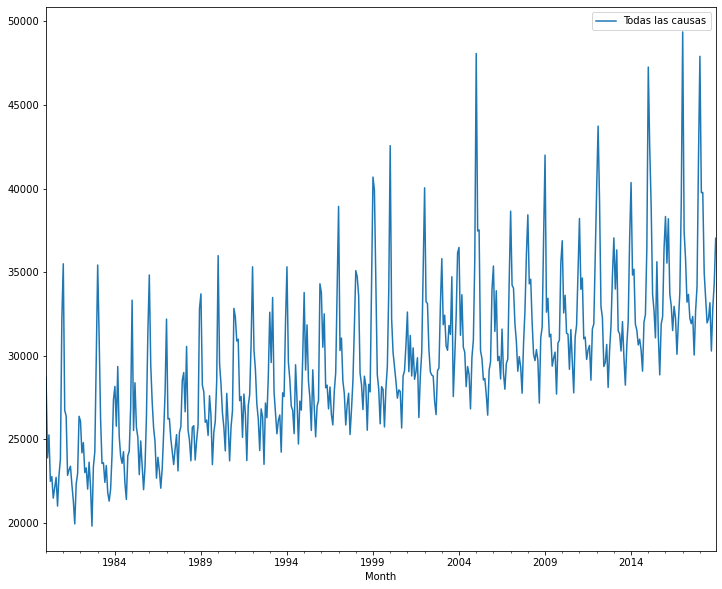

In [7]:
plt.rcParams["figure.figsize"] = (12,10)
defunciones.plot()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
#test de la serie al natural
test_stationarity(defunciones)

Results of Dickey-Fuller Test:
Test Statistic                  -0.942604
p-value                          0.773619
#Lags Used                      14.000000
Number of Observations Used    453.000000
Critical Value (1%)             -3.444868
Critical Value (5%)             -2.867941
Critical Value (10%)            -2.570180
dtype: float64


Una vez representada la serie, hacemos el test de estacionariedad de Dickey-Fuller.

H0: La serie NO es estacionaria \
H1: La serie es estacionaria

Por tanto, nos interesará que el contraste de hipótesis sea rechazado (p-valor < 0.05). 

En este caso obtenemos un p-valor mayor a 0.05 con lo cual debemos aceptar la hipótesis nula, esto significa que la serie en efecto NO es estacionaria. Algo que ya podíamos intuir a ver la tendencia en la representación gráfica.

Procedo ahora a realizar la descomposición de la serie.

## Descomposición de la serie

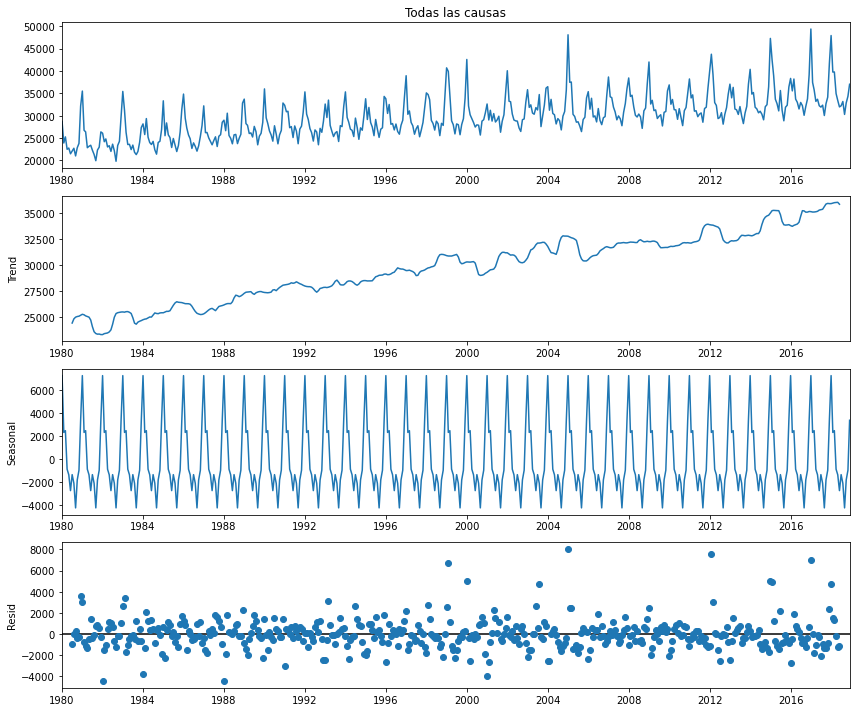

In [10]:
#descomposición aditiva
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicamos descomposición aditiva
defunciones_desc_Ad = seasonal_decompose(defunciones['Todas las causas'], model='additive',period=12)
defunciones_desc_Ad.plot()
plt.show()

In [11]:
#evaluamos estacionariedad de los residuos
test_stationarity(defunciones_desc_Ad.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.833132e+00
p-value                        4.975783e-17
#Lags Used                     1.800000e+01
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


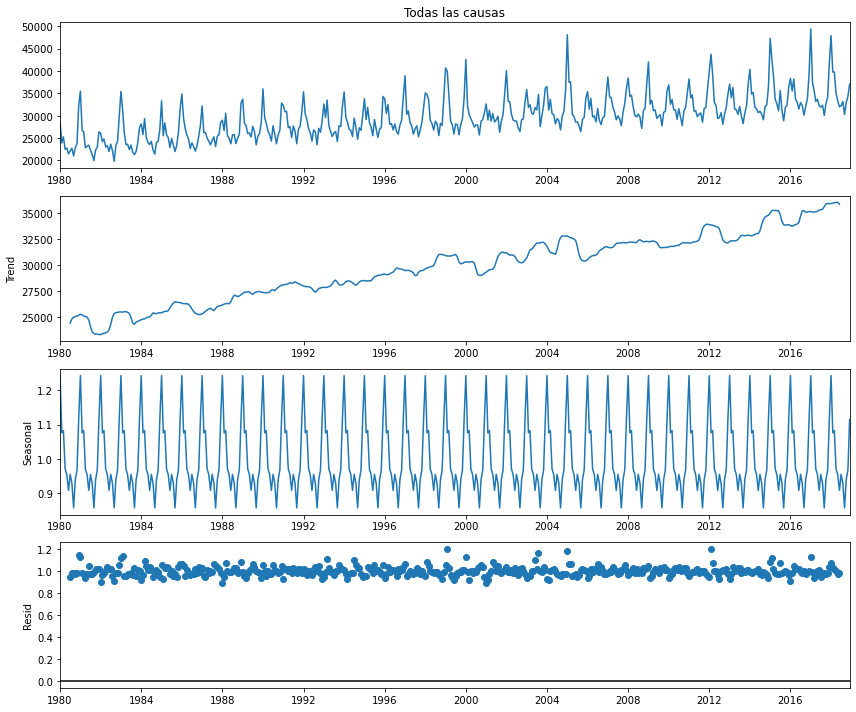

In [12]:
#Descomposicion multiplicativa
defunciones_desc_Mul = seasonal_decompose(defunciones['Todas las causas'], model='multiplicative',period=12)
defunciones_desc_Mul.plot()
plt.show()

In [13]:
#evaluamos estacionariedad de los residuos
test_stationarity(defunciones_desc_Mul.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.977362e+00
p-value                        2.159804e-17
#Lags Used                     1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.868161e+00
Critical Value (10%)          -2.570297e+00
dtype: float64


In [14]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

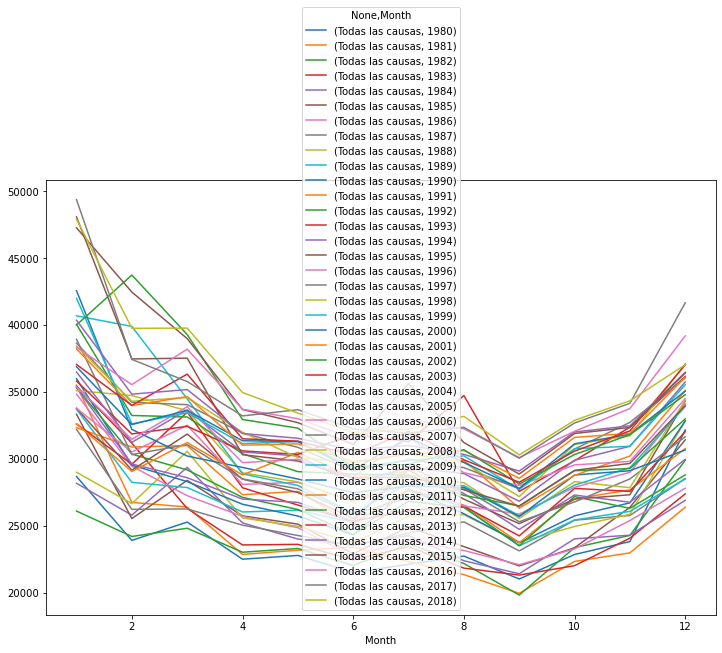

In [15]:
seasonal_plot(defunciones)
plt.show()

## Conclusiones sobre la descomposición

Al descomponer la serie tanto de forma aditiva como multiplicativa, eliminando la tendencia y la estacionalidad, los residuos de ambas descomposiciones pasan el test de estacionariedad. Esto nos confirma que será necesario diferenciar la serie para volverla estacionaria. Cabe mencionar que debido a la heterocedasticidad de la serie, la descomposición multiplicativa funciona mejor y da un p-valor aún más bajo para el test de estacionariedad.

Sobre el seasonal plot, observamos algunas tendencias comunes sobre todo de aumento en los meses de enero y diciembre

### Transformación de la serie a estacionaria

Como pudimos observar de la descomposición, tendremos que diferenciar la serie en lo regular y en lo estacional para volverla estacionaria, adicionalmente probaremos la transformación logarítimica. Seguimos el esquema a continuación:

1. Transformación Logaritmica para la estabilización de la varianza
2. Diferenciación regular
3. Diferenciación estacional

Con la serie resultante, comprobaremos estacionariedad y será con la que podemos valorar autocorrelaciones simples y parciales para proponer órdenes ARIMA tentativos para la serie.


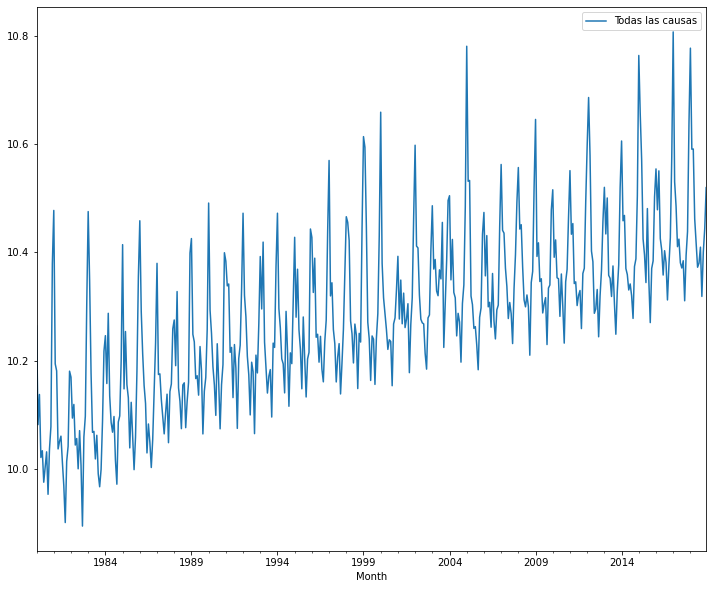

In [16]:
# Transformación Logaritmica para eliminar la heterocedasticidad

defLog = np.log(defunciones)
defLog.plot()
plt.show()

#### Diferenciación regular

Le resto a cada dato, el dato anterior para eliminar la tendencia

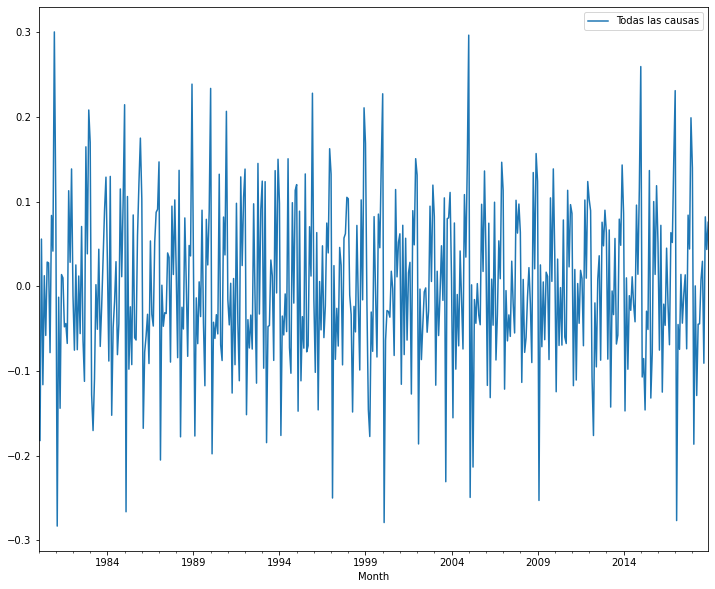

In [17]:
defLog_diff_1 = defLog.diff(periods=1)
defLog_diff_1.plot()
plt.show()

#### Diferenciación estacional

Para eliminar el componente estacional

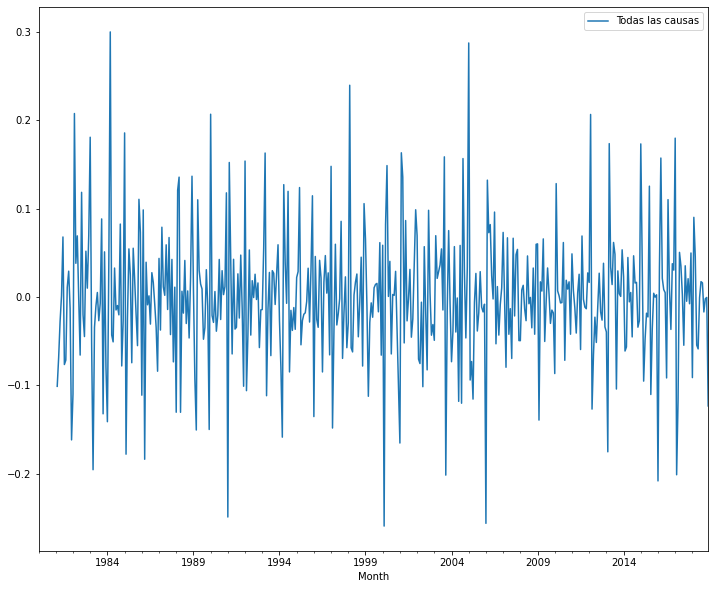

In [18]:
#a la serie diferenciada en lo regular, la diferencio también en lo estacional
defLog_diff_1_12 = defLog_diff_1.diff(periods=12)
defLog_diff_1_12.plot()
plt.show()

#### Comprobación de estacionariedad

Comprobamos ahora la estacionariedad de la serie al natural vs la serie logaritmica, diferenciada en lo regular y en lo estacional

In [19]:
#Con transformacion logaritmica + diferenciacion regular
test_stationarity(defLog_diff_1.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -9.156472e+00
p-value                        2.601666e-15
#Lags Used                     1.300000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [20]:
#Con transformacion logaritmica + diferenciacion regular + diferenciacion estacional
test_stationarity(defLog_diff_1_12.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -1.029023e+01
p-value                        3.586141e-18
#Lags Used                     1.700000e+01
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


## Conclusiones sobre la estacionariedad

La serie transformada a logartimo y diferenciada en lo regular ya sería estacionaria, sin embargo, al diferenciarla en lo estacional también se vuelve más estacionaria aún con un p-valor que es el más bajo de todos.

### Autocorrelaciones 

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

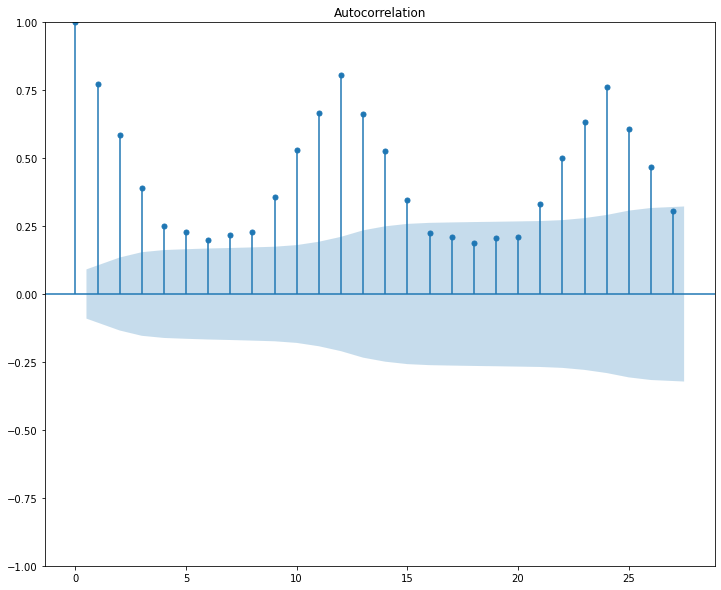

In [22]:
#correlograma de la serie al natural
plot_acf(defunciones.dropna(inplace=False))
plt.show()


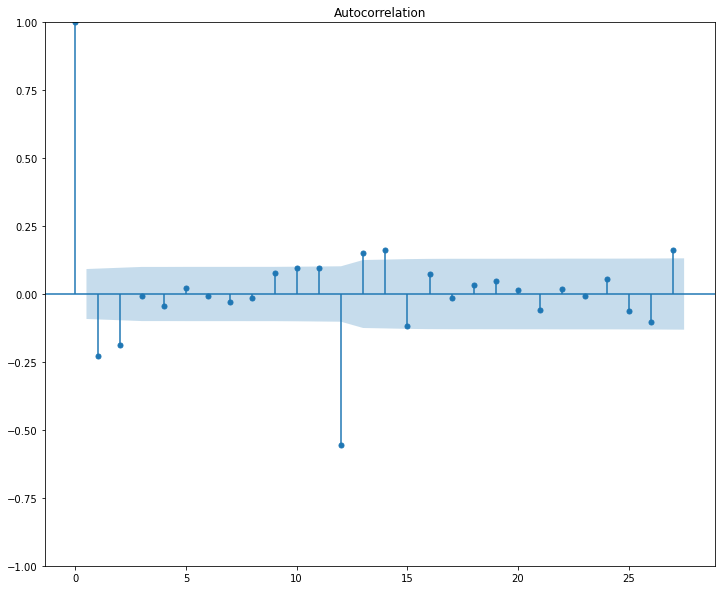

In [23]:
#correlograma de la serie transformada a logaritmo y diferenciada en lo regular y estacional
plot_acf(defLog_diff_1_12.dropna(inplace=False))
plt.show()

## Partición training y test (dejamos como test los últimos 2 años de datos).

In [24]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def_tr = defLog[:'2016-12-01']
def_tst = defLog['2017-01-01':]
def_tst

,Todas las causas
Month,
2017-01-01,10.807098
2017-02-01,10.530335
2017-03-01,10.485116
2017-04-01,10.410546
2017-05-01,10.424452
2017-06-01,10.380839
2017-07-01,10.371113
2017-08-01,10.384555
2017-09-01,10.310585


## Modelos de suavizado exponencial.

## Modelos de suavizado

Buscamos que:

1- Los residuos pasen el test Ljung-box, es decir, p-valores altos (mayores a 0.05) que implicaría falta de correlación por la H0 del test \
2- Que el error (MAPE) sea lo menor posible\
3- Y que la serie real en test se parezca a la predicción que hace el modelo para el test

La siguiente función nos ayudará a evaluar todo esto

In [25]:
#forecast_accuracy(fc, test.values)

# Función para evaluar modelo
def eval_model(model,tr,tst,name='Model',lags=12):
    #sacamos el df de los 12 periodos y sus p-valores y calcular una media
    #si en media los valores son superiores a 0.05 podemos decir que esas autocorrelaciones no son significativas en media en todo el periodo
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    #obtenemos las predicciones con el forecast para tantos periodos como tenga el archivo de tst
    pred = model.forecast(steps=len(tst))
    fig1, ax = plt.subplots()
    ax.plot(tr, label='training')
    ax.plot(tst, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel('Pasajeros')
    plt.xlabel('Date')
    plt.show()
    print(lb)

In [26]:
#Modelo de suavizado exponencial simple
ses = ets.SimpleExpSmoothing(def_tr).fit()
ses.summary()

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Todas las causas,No. Observations:,444
Model:,SimpleExpSmoothing,SSE,4.140
Optimized:,True,AIC,-2071.786
Trend:,None,BIC,-2063.595
Seasonal:,None,AICC,-2071.695
Seasonal Periods:,None,Date:,"Thu, 09 Mar 2023"
Box-Cox:,False,Time:,17:53:01
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9195947,alpha,True
initial_level,10.249631,l.0,True


### Evaluación del modelo SES

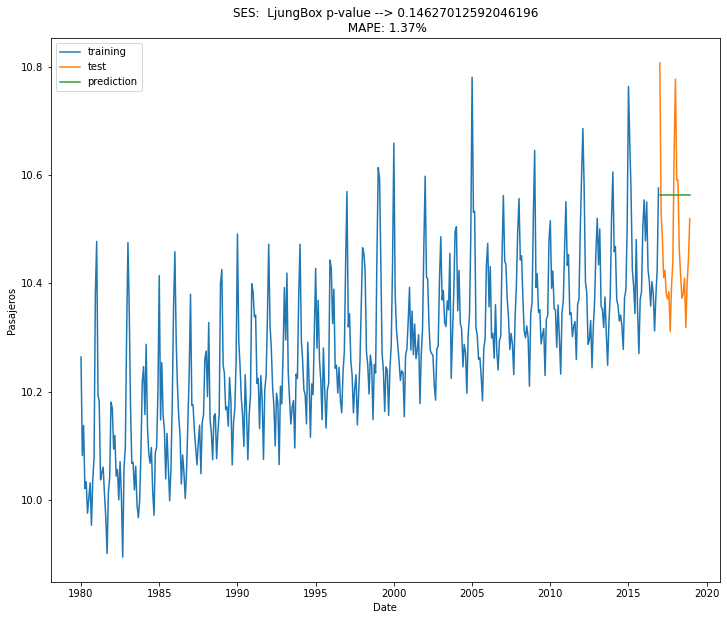

0.14627012592046196


In [27]:
# Evaluar SES
eval_model(ses,def_tr,def_tst,'SES')

### Suavizado doble de Holt

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


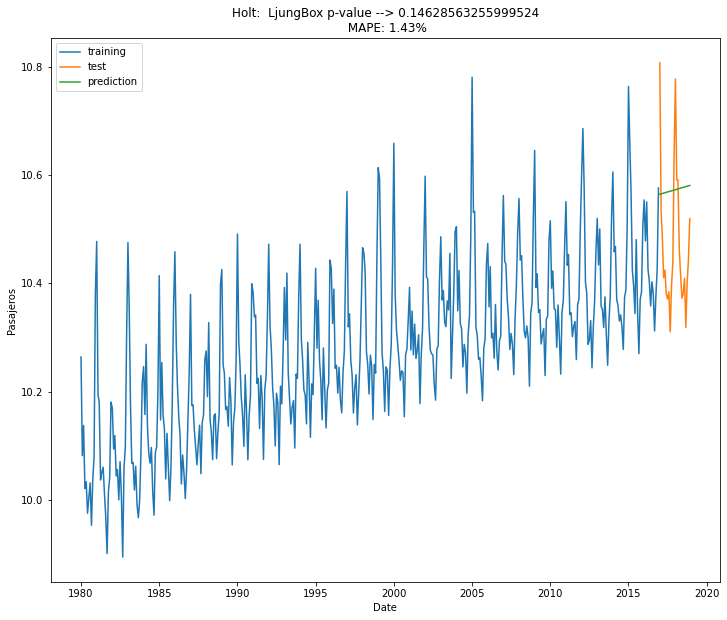

0.14628563255999524


In [28]:
# Suavizado de Holt
holt = ets.Holt(def_tr).fit()
holt.summary()

eval_model(holt,def_tr,def_tst,'Holt')


#### Suavizado de Holt Winters Aditivo

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


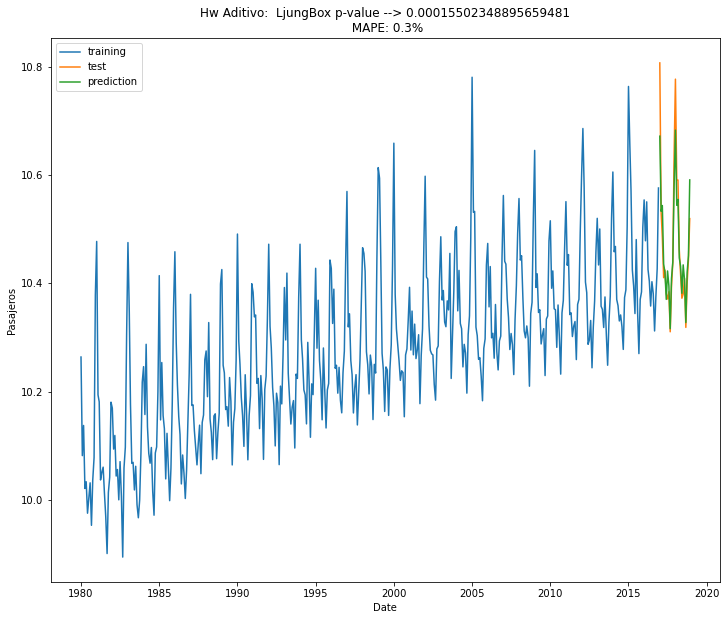

0.00015502348895659481


In [29]:
hw_add = ets.ExponentialSmoothing(def_tr,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()

eval_model(hw_add,def_tr,def_tst,'Hw Aditivo')

#### Suavizado de Holt Winters Multiplicativo 

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


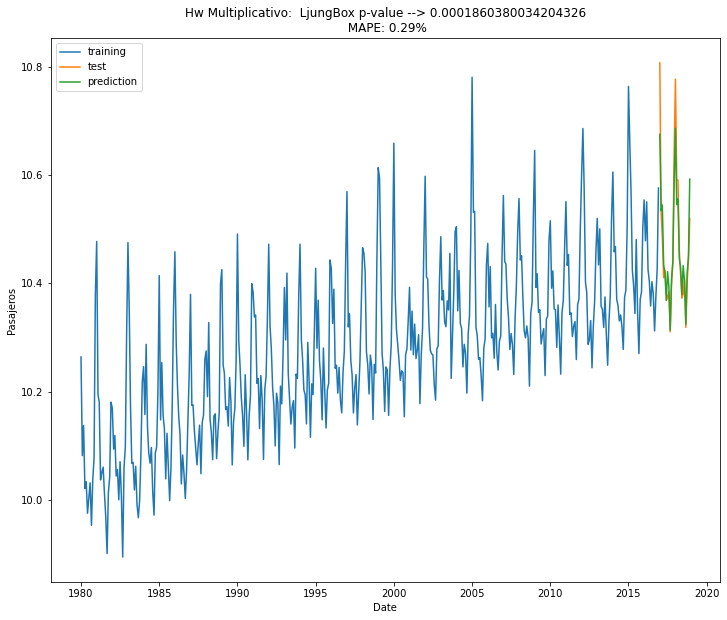

0.0001860380034204326


In [30]:
hw_mul = ets.ExponentialSmoothing(def_tr,trend='mul', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()

eval_model(hw_mul,def_tr,def_tst,'Hw Multiplicativo')

## Modelos de suavizado exponencial - Conclusiones

De todos los métodos de suavizado, el mejor modelo hasta ahora es en cuanto a error (MAPE) y mejor capacidad predictiva el holt winters multiplicativo sobre la serie transformada a logaritmo. Sin embargo, a pesar de tener mejor capacidad predictiva, no pasa el test de Ljung-box, con un resultado menor a 0.05, con lo cual no podemos decir que los residuos no están correlacionados.

El SES y el doble de Holt sí que superan el test Ljung-box pero se observa claramente como no son modelos adecuados para la predicción. 

## Modelos ARIMA.

In [31]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
        
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
        
    Lags should be min(2*seasonal_period, T/5)
        
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
        
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax 

In [32]:
# Función para evaluar modelo auto_arima
def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
      lb = np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=lags, return_df=True).lb_pvalue)
      pred = model.predict(n_periods=len(tst))
      fig1, ax = plt.subplots()
      ax.plot(tr, label='training')
      ax.plot(tst, label='test')
      ax.plot(pred, label='prediction')
      plt.legend(loc='upper left')
      tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
      plt.title(tit)
      plt.ylabel('Serie')
      plt.xlabel('Date')
      plt.show()
      model.plot_diagnostics(figsize=(14,10))
      plt.show()  

## Arima Manual

En este caso utilizaremos SARIMAX de statsmodels para ajustar opciones de modelos ARIMA manuales. Para ello, en primer lugar evaluaremos las autocorrelaciones para identificar patrones de efectos AR (autoregresivos) y MA (medias móviles) tentativos. Una vez tenemos una idea de los órdenes a proponer, ajustamos los modelos. 

Realizamos correlogramas de la serie logaritmica, doblemente diferenciada. 

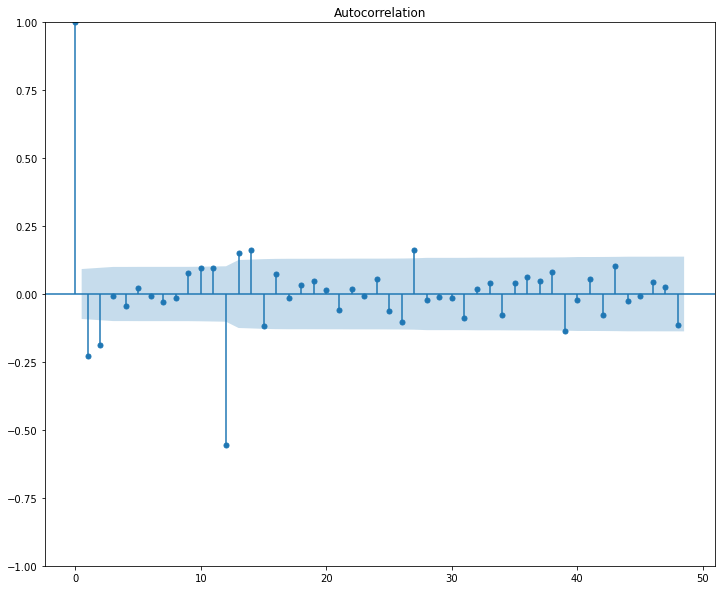

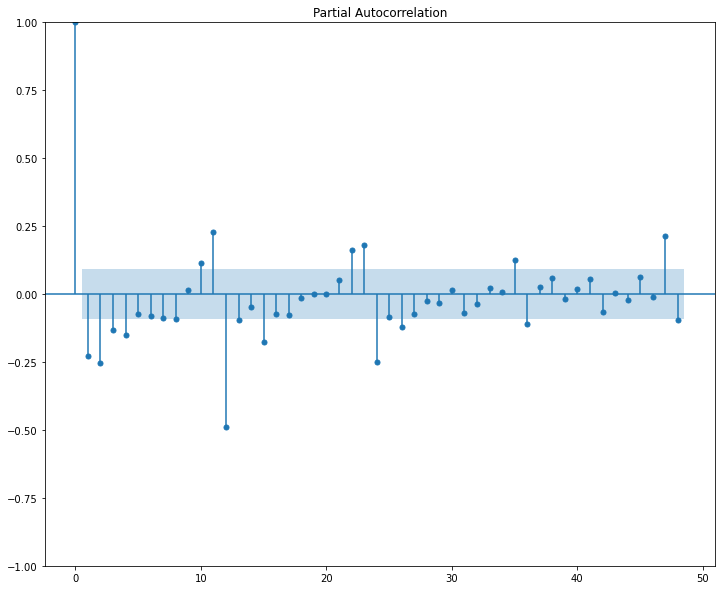

In [33]:
#diagrama de autocorrelacion simple
plot_acf(defLog_diff_1_12.dropna(inplace=False),lags=48)
plt.show()

#diagrama de autocorrelacion parcial
plot_pacf(defLog_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

#serie totalmente diferenciada en este caso

### Comentarios:

En lo regular:
- Observamos que hay decrecimiento en PACF y corte en ACF en el retardo 2 que es el último retardo significativo, con lo cual intentaremos con un MA2.
- Parece también haber decrecimiento en ACF y corte en PACF, sin embargo el corte se da en el retardo 4 que es el último retardo significativo. Esto nos indica que es posible que haya una superposición de AR y MA, con lo cual probaremos también considerando ambos efectos AR1 y MA1.

En lo estacional:
- Observamos que ACF se corta en el retardo 12 y los retardos 24 y 36 no son significativos, con lo cual probaremos con un MA1 en lo estacional.
- En PACF observamos que el retardo 12 y 24 son significativos e incluso el 36 supera las bandas de confianza por un poco, por tanto probaremos con AR1 también en lo estacional.

**Modelo 1** -> ARIMA (1,1,1)(1,1,1,12)
Superposición de efectos ARMA, AR1, MA1 tanto en lo regular como en lo estacional, y diferenciada tanto en lo regular como en lo estacional.

In [50]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima1 = SARIMAX(def_tr, 
                order = (1, 1, 1), 
                seasonal_order =(1, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41303D+00    |proj g|=  6.55114D+00

At iterate    5    f= -1.51784D+00    |proj g|=  3.89599D+00

At iterate   10    f= -1.56834D+00    |proj g|=  2.49228D+00

At iterate   15    f= -1.59016D+00    |proj g|=  1.71161D-01

At iterate   20    f= -1.61052D+00    |proj g|=  3.48362D-01

At iterate   25    f= -1.62066D+00    |proj g|=  3.75583D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 719.635
Date:                            Thu, 09 Mar 2023   AIC                          -1429.270
Time:                                    17:59:52   BIC                          -1408.939
Sample:                                01-01-1980   HQIC                         -1421.242
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4419      0.045      9.800      0.000       0.354       0.530
ma.L1         -0.9689      0.021    -45.811      0.000      -1.010      -0.927
ar.S.L12      -0.1498      0.037     -4.009      0.000      -0.223      -0.077
ma.S.L12      -0.9906      0.168     -5.908      0.000      -1.319      -0.662
sigma2         0.0019      0.000      6.235      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               357.55
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.08
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

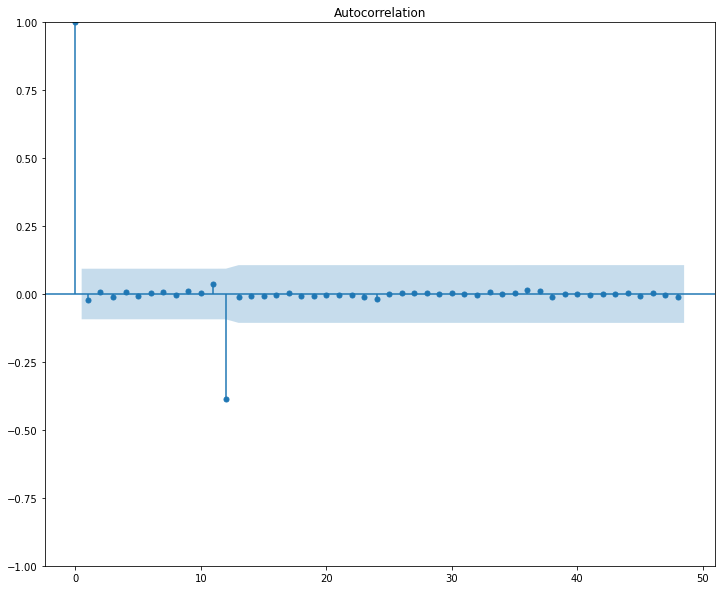

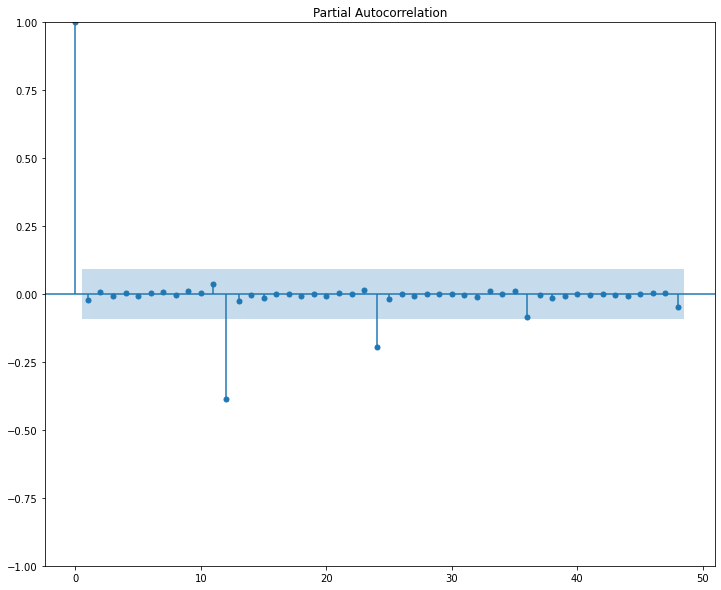

In [51]:
#observamos ACF y PACF de residuos con el modelo arima1
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()

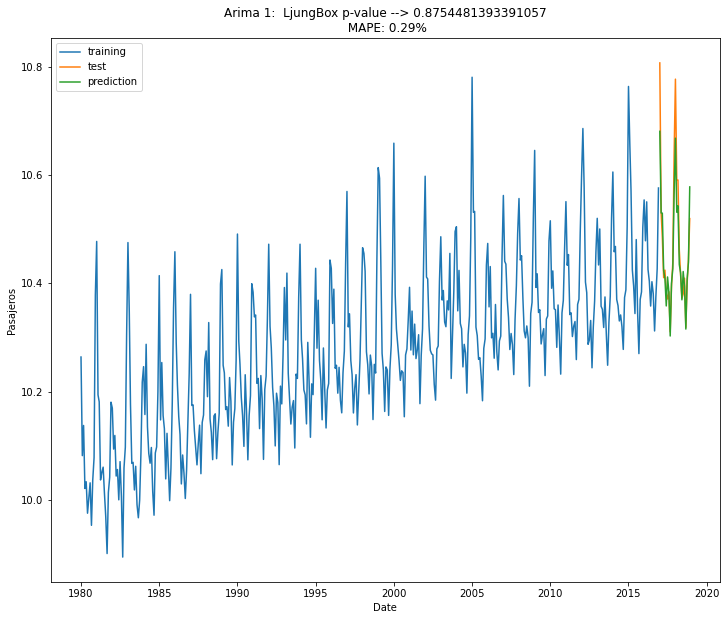

0.8754481393391057


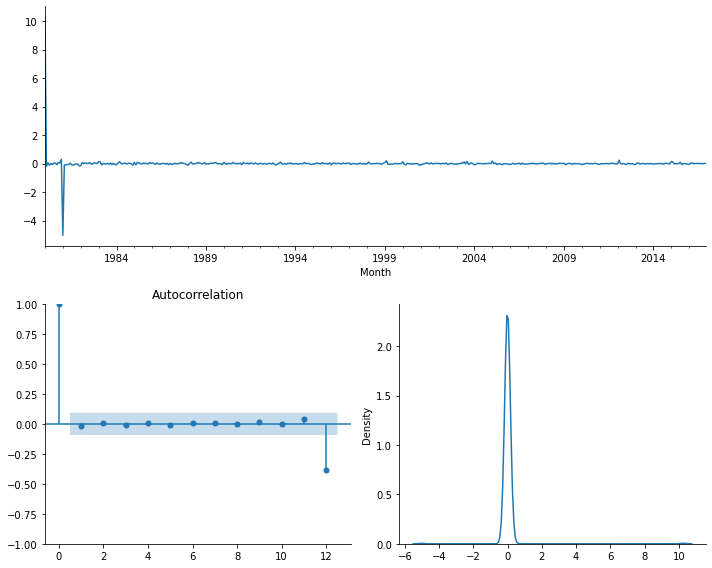

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [52]:
eval_model(arima_1,def_tr,def_tst,'Arima 1')
residcheck(arima_1.resid,12)

**Modelo 2** ARIMA (0,1,2)(0,1,1,12). Probamos con un MA2 en lo regular y MA1 en lo estacional, y diferenciada tanto en lo regular como en lo estacional.

In [37]:
arima2 = SARIMAX(def_tr, 
                order = (0, 1, 2), 
                seasonal_order =(0, 1, 1,12))
  
arima_2 = arima2.fit()
arima_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44295D+00    |proj g|=  7.06689D+00


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.53939D+00    |proj g|=  2.86283D-01

At iterate   10    f= -1.55135D+00    |proj g|=  3.53348D+00

At iterate   15    f= -1.57104D+00    |proj g|=  2.28311D-01

At iterate   20    f= -1.57743D+00    |proj g|=  2.38117D+00

At iterate   25    f= -1.59690D+00    |proj g|=  6.06772D-02

At iterate   30    f= -1.59693D+00    |proj g|=  7.61609D-02

At iterate   35    f= -1.59765D+00    |proj g|=  3.74218D-01

At iterate   40    f= -1.59835D+00    |proj g|=  1.21614D-01

At iterate   45    f= -1.59854D+00    |proj g|=  9.08791D-04

At iterate   50    f= -1.59856D+00    |proj g|=  1.88345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 709.760
Date:                              Thu, 09 Mar 2023   AIC                          -1411.521
Time:                                      17:53:09   BIC                          -1395.256
Sample:                                  01-01-1980   HQIC                         -1405.099
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5482      0.040    -13.543      0.000      -0.627      -0.469
ma.L2         -0.3992      0.043     -9.311      0.000      -0.483      -0.315
ma.S.L12      -0.9959      0.424     -2.350      0.019      -1.827      -0.165
sigma2         0.0020      0.001      2.407      0.016       0.000       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):               346.66
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             1.01
Prob(H) (two-sided):                  0.16   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

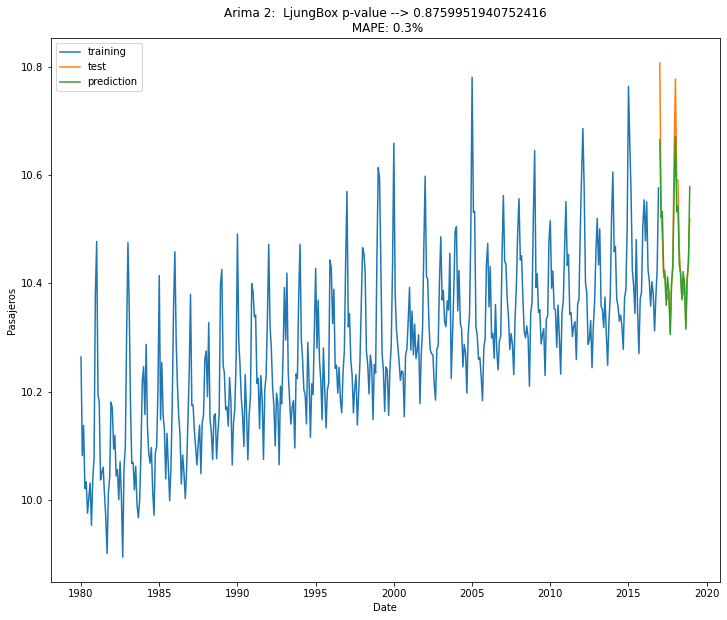

0.8759951940752416


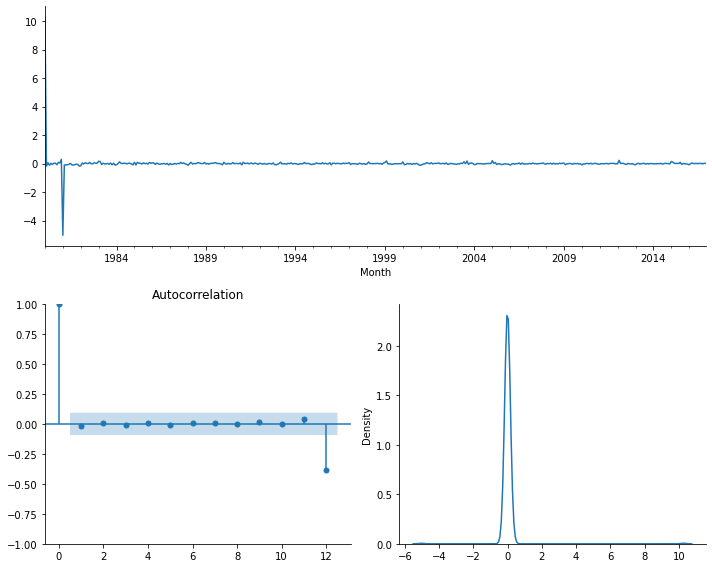

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.876 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [38]:
eval_model(arima_2,def_tr,def_tst,'Arima 2')
residcheck(arima_2.resid,12)

**Modelo 3** ARIMA (1,1,2)(1,1,1,12). Superposición de efectos ARMA, AR1 y MA2 en lo regular, MA1 en lo estacional, y diferenciada tanto en lo regular como en lo estacional.

In [39]:
arima3 = SARIMAX(def_tr, 
                order = (1, 1, 2), 
                seasonal_order =(1, 1, 1,12))
  
arima_3 = arima3.fit()
arima_3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42393D+00    |proj g|=  6.37216D+00


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.53331D+00    |proj g|=  1.74390D+00

At iterate   10    f= -1.58251D+00    |proj g|=  2.62448D-01

At iterate   15    f= -1.58940D+00    |proj g|=  1.68397D-01

At iterate   20    f= -1.59151D+00    |proj g|=  5.02001D-02

At iterate   25    f= -1.60701D+00    |proj g|=  2.18550D+00

At iterate   30    f= -1.62098D+00    |proj g|=  1.42434D-01

At iterate   35    f= -1.62129D+00    |proj g|=  2.26940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     48      1     0     0   5.636D-03  -1.621D+00
  F =  -1.6212892639239871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 719.852
Date:                              Thu, 09 Mar 2023   AIC                          -1427.705
Time:                                      17:53:12   BIC                          -1403.308
Sample:                                  01-01-1980   HQIC                         -1418.072
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3806      0.107      3.556      0.000       0.171       0.590
ma.L1         -0.8939      0.114     -7.851      0.000      -1.117      -0.671
ma.L2         -0.0712      0.104     -0.686      0.492      -0.275       0.132
ar.S.L12      -0.1498      0.038     -3.989      0.000      -0.223      -0.076
ma.S.L12      -0.9914      0.185     -5.368      0.000      -1.353      -0.629
sigma2         0.0019      0.000      5.642      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               359.55
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.09
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

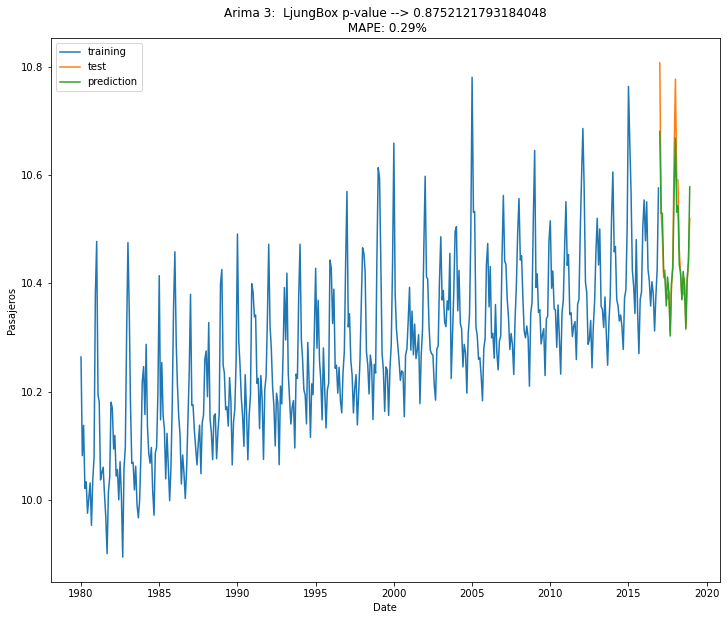

0.8752121793184048


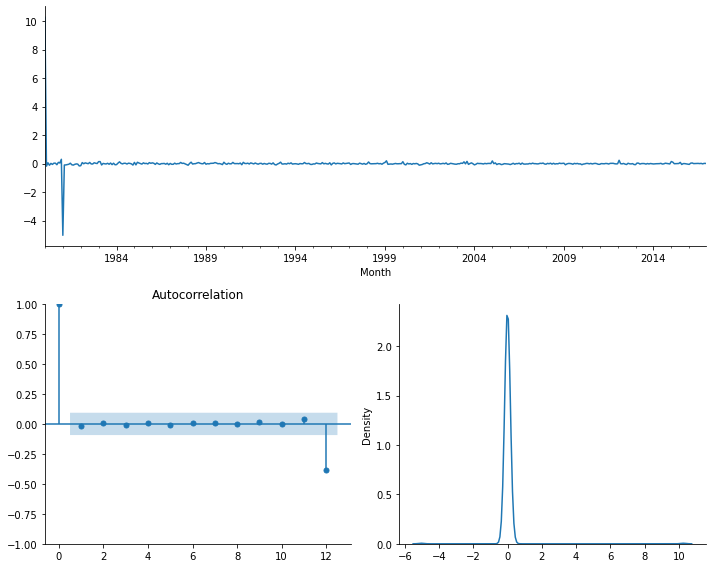

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [40]:
eval_model(arima_3,def_tr,def_tst,'Arima 3')
residcheck(arima_3.resid,12)

**Modelo 4** ARIMA (2,1,2)(0,1,1,12). Superposición de efectos ARMA, AR2 y MA2 en lo regular, MA1 en lo estacional, y diferenciada tanto en lo regular como en lo estacional.

In [41]:
arima4 = SARIMAX(def_tr, 
                order = (2, 1, 2), 
                seasonal_order =(0, 1, 1,12))
  
arima_4 = arima4.fit()
arima_4.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44892D+00    |proj g|=  7.18634D+00


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.54899D+00    |proj g|=  3.62329D-01

At iterate   10    f= -1.56007D+00    |proj g|=  2.08671D+00

At iterate   15    f= -1.56331D+00    |proj g|=  3.91703D-01

At iterate   20    f= -1.57761D+00    |proj g|=  3.33136D+00

At iterate   25    f= -1.60619D+00    |proj g|=  9.73042D-02

At iterate   30    f= -1.60774D+00    |proj g|=  3.85072D-01

At iterate   35    f= -1.60891D+00    |proj g|=  1.49928D-02

At iterate   40    f= -1.60895D+00    |proj g|=  1.38379D-01

At iterate   45    f= -1.61060D+00    |proj g|=  5.09841D-01

At iterate   50    f= -1.61142D+00    |proj g|=  1.71564D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 715.473
Date:                              Thu, 09 Mar 2023   AIC                          -1418.945
Time:                                      17:53:16   BIC                          -1394.549
Sample:                                  01-01-1980   HQIC                         -1409.313
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3599      0.427     -0.842      0.400      -1.197       0.478
ar.L2          0.3602      0.227      1.587      0.113      -0.085       0.805
ma.L1         -0.1425      0.419     -0.340      0.734      -0.964       0.679
ma.L2         -0.8103      0.414     -1.958      0.050      -1.621       0.001
ma.S.L12      -0.9806      0.094    -10.480      0.000      -1.164      -0.797
sigma2         0.0019      0.000     10.702      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               336.01
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

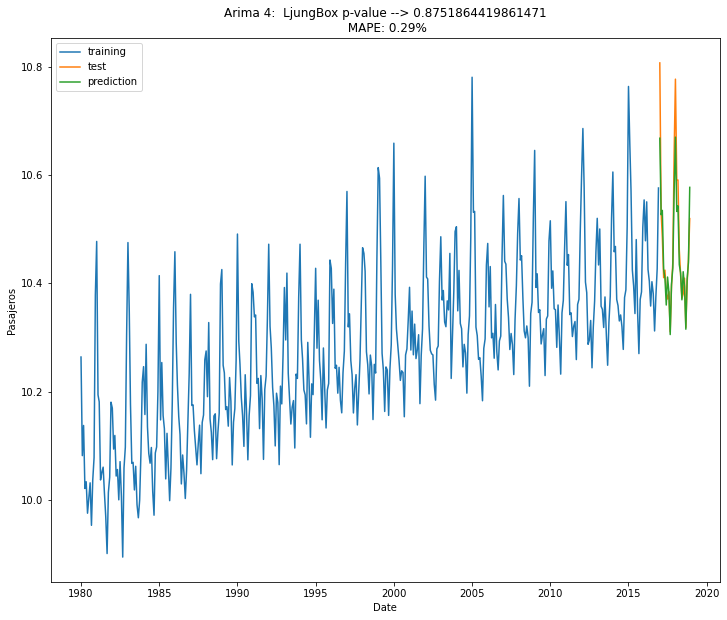

0.8751864419861471


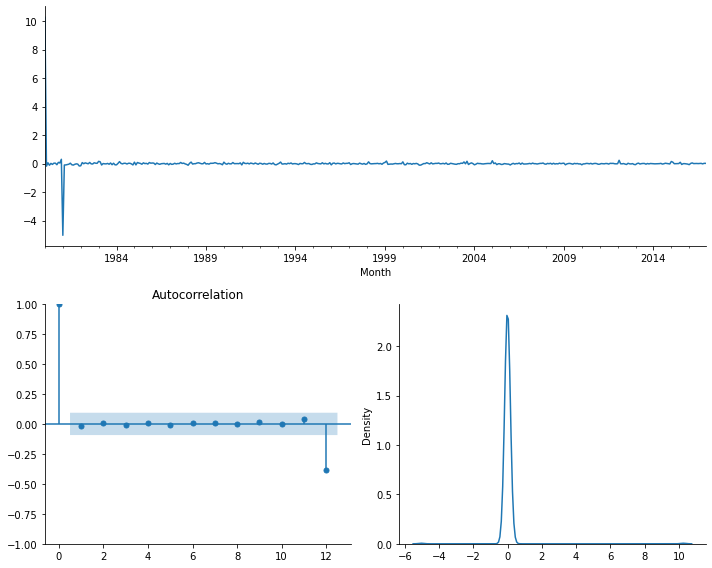

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [42]:
eval_model(arima_4,def_tr,def_tst,'Arima 4')
residcheck(arima_4.resid,12)

**Modelo 5** ARIMA (1,1,2)(2,1,1,12). Superposición de efectos ARMA, AR1 y MA2 en lo regular, AR2 y MA1 en lo estacional, y diferenciada tanto en lo regular como en lo estacional.

In [43]:
arima5 = SARIMAX(def_tr, 
                order = (1, 1, 2), 
                seasonal_order =(2, 1, 1,12))
  
arima_5 = arima5.fit()
arima_5.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42168D+00    |proj g|=  6.33571D+00


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.49888D+00    |proj g|=  1.73585D+00

At iterate   10    f= -1.50877D+00    |proj g|=  5.67061D-01

At iterate   15    f= -1.53135D+00    |proj g|=  2.81086D+00

At iterate   20    f= -1.55929D+00    |proj g|=  1.79755D+00

At iterate   25    f= -1.57399D+00    |proj g|=  2.49647D-01

At iterate   30    f= -1.59086D+00    |proj g|=  3.91791D-01

At iterate   35    f= -1.62124D+00    |proj g|=  2.52270D-01

At iterate   40    f= -1.62149D+00    |proj g|=  5.41333D-02

At iterate   45    f= -1.62153D+00    |proj g|=  3.22386D-03
  ys=-2.343E-07  -gs= 3.319E-07 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     72      1     1     0   3.224D-03  -1.622D+00
  F =  -1.6215347963192588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 719.961
Date:                              Thu, 09 Mar 2023   AIC                          -1425.923
Time:                                      17:53:28   BIC                          -1397.460
Sample:                                  01-01-1980   HQIC                         -1414.685
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3771      0.108      3.508      0.000       0.166       0.588
ma.L1         -0.8907      0.115     -7.755      0.000      -1.116      -0.666
ma.L2         -0.0736      0.105     -0.704      0.481      -0.279       0.131
ar.S.L12      -0.1550      0.042     -3.663      0.000      -0.238      -0.072
ar.S.L24      -0.0231      0.051     -0.454      0.650      -0.123       0.077
ma.S.L12      -0.9855      0.119     -8.271      0.000      -1.219      -0.752
sigma2         0.0019      0.000      9.037      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               354.07
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

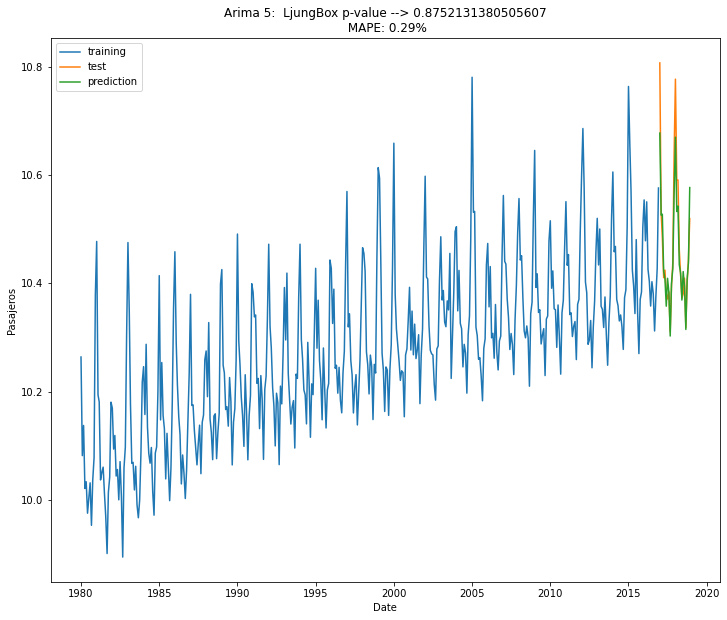

0.8752131380505607


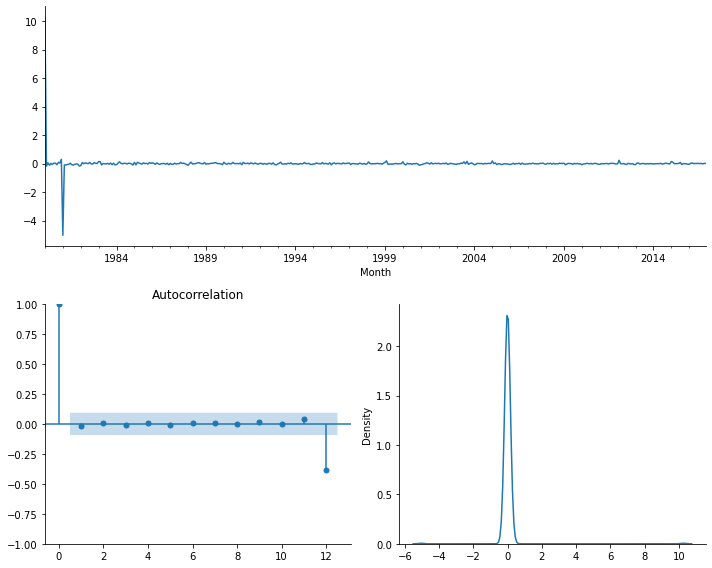

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [44]:
eval_model(arima_5,def_tr,def_tst,'Arima 5')
residcheck(arima_5.resid,12)

### Conclusiones Mejor Modelo ARIMA

En cuanto a los modelos ARIMA hay una clara superposición de ambos, de lo que se puede observar en los gráficos de ACF y PACF. Ya que hay decrecimiento en PACF y corte en ACF (MA), así como también decrecimiento en ACF y corte en PACF (AR). 

En cuanto a los resultados de los modelos: comparten valores muy parecidos para MAPE y p-value, en este caso todos pasan el test de Ljung-box, lo cual nos indican que los residuos no están correlacionados.

- ARIMA (1,1,1)(1,1,1,12) - MAPE: 0.29% p-value: 0.8754
- ARIMA (0,1,2)(0,1,1,12) - MAPE: 0.3% p-value: 0.8759
- ARIMA (1,1,2)(1,1,1,12) - MAPE: 0.29% p-value: 0.8752
- ARIMA (2,1,2)(0,1,1,12) - MAPE: 0.29% p-value: 0.8751
- ARIMA  (1,1,2)(2,1,1,12) - MAPE: 0.29% p-value: 0.8752

**El mejor modelo ARIMA en cuanto a MAPE más bajo y p-value más alto sería el ARIMA (1,1,1)(1,1,1,12). También resulta ser un buen equilibrio entre un modelo simple y con buen desempeño. Este modelo pasa el test Ljung-box.**

## Arima automático

In [45]:
import pmdarima as pm

# Ajustamos modelo arima step-wise con métrica AIC para la serie
arima_auto = pm.auto_arima(def_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-1239.581, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-424.481, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1187.592, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-904.066, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3331.164, Time=0.03 sec


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-1006.924, Time=1.18 sec


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-1185.468, Time=1.03 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1275.161, Time=4.65 sec


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1281.931, Time=4.29 sec


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-805.524, Time=2.78 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.85 sec


/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-1258.240, Time=5.75 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=-1279.664, Time=4.81 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=-1126.432, Time=3.55 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-1273.715, Time=4.31 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-1258.976, Time=6.57 sec
 ARIMA(1,0,1)(2,0,0)[12]             : AIC=-1207.720, Time=2.01 sec

Best model:  ARIMA(1,0,1)(2,0,0)[12] intercept
Total fit time: 51.221 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  444
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                 646.966
Date:                             Thu, 09 Mar 2023   AIC                          -1281.931
Time:                                     17:54:20   BIC                          -

/Users/andreac.henechesierra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


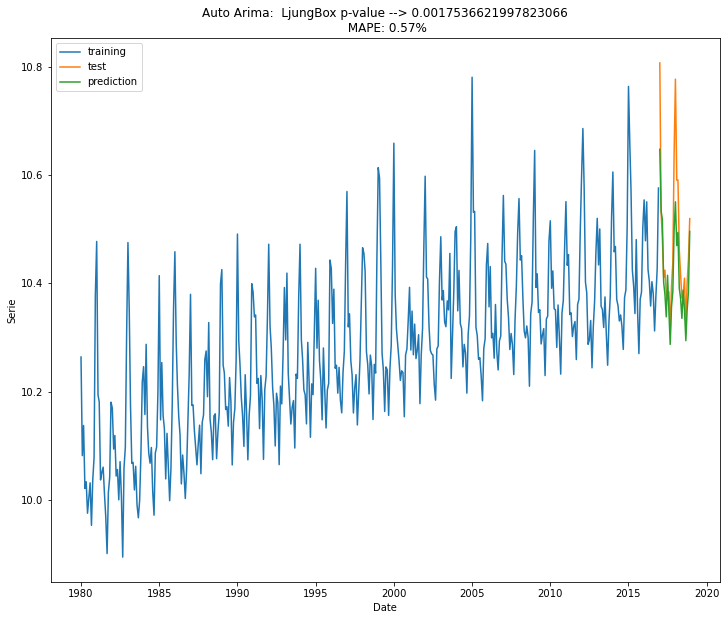

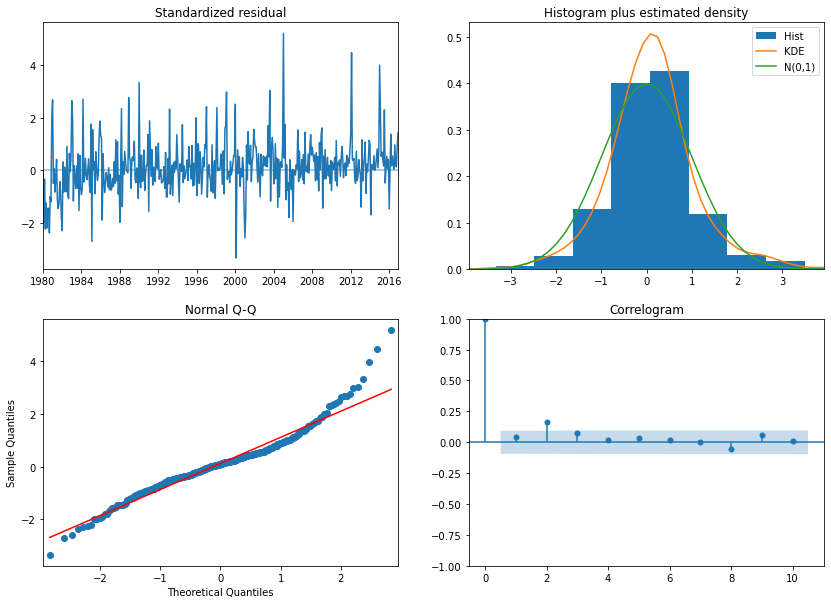

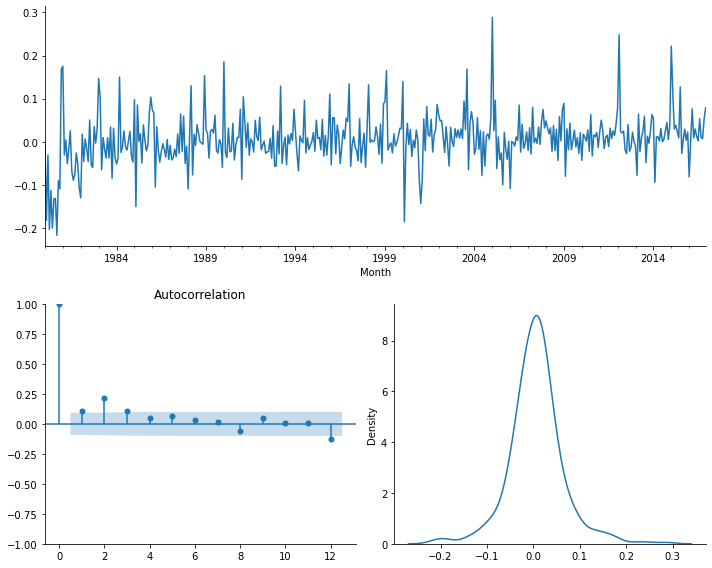

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.002 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.001 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [46]:
eval_model_Aarima(arima_auto,def_tr,def_tst,'Auto Arima')
residcheck(arima_auto.resid(),12)

# Comparación.

En cuanto a mayor precisión, es decir, menor MAPE, de todos los modelos, considerando los de suavizado y los ARIMA (incluyendo el automático), los modelos ARIMA manuales comparten casi todos el mismo MAPE, sin embargo en cuanto a combinación de menor MAPE y p-valor más alto, el modelo que resulta mejor es el **ARIMA (1,1,1)(1,1,1,12)**, cabe destacar también que el modelo **Holt Winters Multiplicativo** comparte el mismo MAPE, es decir, buena capacidad predictiva, pero lamentablemente no pasa el test Ljung-box, lo cual indica que sus residuos están correlacionados. Por lo que la mejor opción en este caso es el modelo ARIMA antes mencionado, el cual se puede observar del gráfico se adapta bastante bien a la serie real. 

El modelo de arima automático no pasa el test Ljung-box y tiene un mayor MAPE, con lo cual es peor que todos los ARIMA manuales antes descritos.

Decidimos quedarnos con el modelo ARIMA antes mencionado por su buen desempeño y su simplicidad, se trata de un modelo diferenciado en lo regular y lo estacional, con previa transformación logarítmica de la serie, y con AR1 y MA1 en lo regular, así como AR1 y MA1 en lo estacional.
